In [2]:
from src import func1 as f1
from src import linear_program as lp
import pandas as pd
import numpy as np
import importlib
from matplotlib import pyplot as plt
import geopandas as gpd


# Download the neccessary data

In [3]:
zip_geo_data = f1.load_zip_geo_data('data/zip_shapes/zip_geo_data.shp')
provider_data = f1.load_provider_data()
year_rates_data = f1.load_rates_data()
states_geo_data = f1.load_states_geo_data('data/state_shapes/states_geo_data.shp')

svi_zips = pd.read_csv('data/ZipData.csv')
svi_zips['ZIP'] = svi_zips['GEO_ID'].str[-5:]
svi_zips = svi_zips.drop(columns=['MedPop'])
DIST_THRESH = 16

c:\Users\kcall\OneDrive - Gainwell Technologies\Documents\Underserved_otp\src\func1.py:177: DtypeWarning: Columns (12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  rates_data = pd.read_csv('data/prescribing_rates.csv')


# Pennsylvania

First we will create a scatter plot of the distances from the nearest OTP provider with the total number of opioid claims to get an idea for the access to on OTP. We also show it in a map where the red dots indicate an OTP provider.

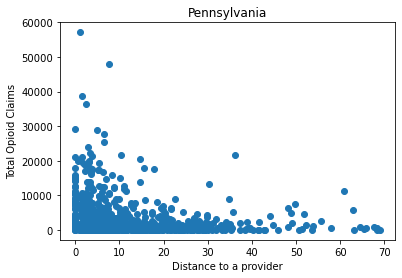

c:\Users\kcall\OneDrive - Gainwell Technologies\Documents\Underserved_otp\src\func1.py:313: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return provider_with_geo['geometry'].centroid


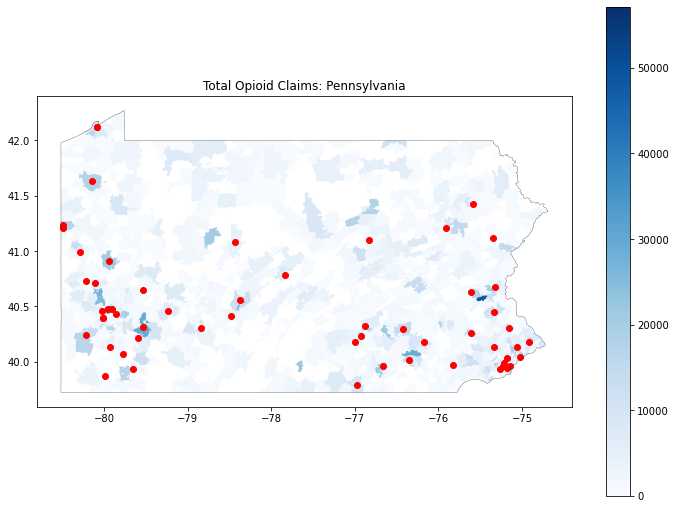

In [4]:
state = 'Pennsylvania'
f1.distance_scatter_plot(zip_geo_data, provider_data, year_rates_data, state)
f1.plot_rates(states_geo_data, zip_geo_data, year_rates_data, provider_data, 'Tot_Opioid_Clms', state)

Next we show the distance from every zip code to it's nearest OTP provider.

c:\Users\kcall\OneDrive - Gainwell Technologies\Documents\Underserved_otp\src\func1.py:313: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return provider_with_geo['geometry'].centroid


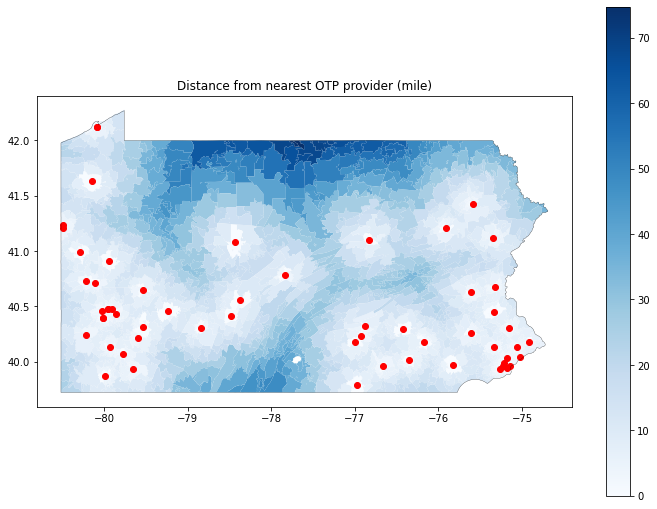

In [5]:
f1.plot_dist_to_providers(zip_geo_data, states_geo_data, provider_data, state)

We can see from this map that those in the north part of the state can travel 70 miles to reach the nearest OTP provider. Even those in some of the more central areas would need to travel 30-40 miles to reach a provider.

Next we use a linear programming technique to assign each person in a zip code to optimally assign each person to their nearest OTP provider (within 16 miles) without exceeding the OTP providers capacity. After the assignments there are people who were not assigned to an OTP provider as there is not an OTP provider sufficiently close enough or the ones that are close are over capacity. We show those on a map of the state along with a table with the 5 zip codes that have the highest number of these people that were not assigned.

c:\Users\kcall\Miniconda3\lib\site-packages\geopandas\geodataframe.py:1350: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
c:\Users\kcall\OneDrive - Gainwell Technologies\Documents\Underserved_otp\src\linear_program.py:145: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: ESRI:102008
Right CRS: None

  distances = gpd.GeoSeries(merged['RATES CENTERS']).distance(gpd.GeoSeries(merged['PROVIDER CENTERS']), align=False)


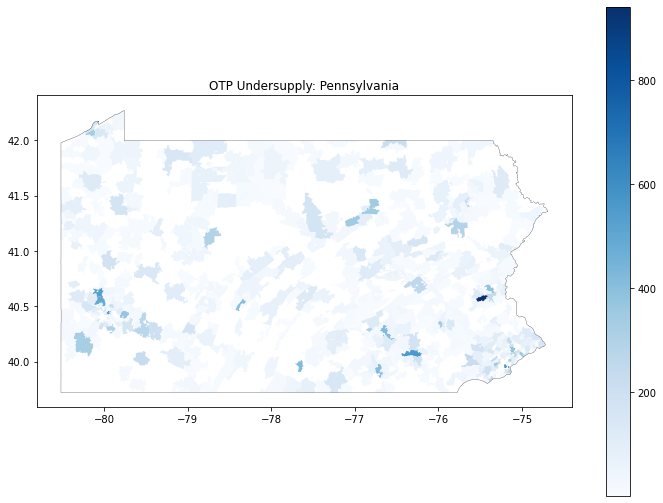

,Undersupply,City
RATES ZIP,,
19107,941.0,Philidelphia
18103,934.0,Allentown
15213,706.0,Pittsburg
19104,590.0,Philidelphia
17601,561.0,Lancaster


In [6]:
penn_lp = lp.run_model(provider_data, zip_geo_data, year_rates_data, state, DIST_THRESH, True)
top_unassigned = penn_lp[1].sort_values('picked', ascending=False).reset_index(level=[1])[:5]
top_unassigned['City'] = ['Philidelphia', 'Allentown', 'Pittsburg', 'Philidelphia', 'Lancaster']
top_unassigned['Undersupply'] = top_unassigned['picked']
top_unassigned[['Undersupply', 'City']]

While there are people who are unassigned because of no OTP provider near them, it is more common that there are OTP providers in the area but they are over capacity. We can see this in Philidelphia. There are multiple OTP providers in the area but still two of its zip codes are in the top 5 for the most people who are not assigned to an OTP provider.

# SVI 

Next we look into how these number of unassigned people relates to the social vulnerability index of the zip code.

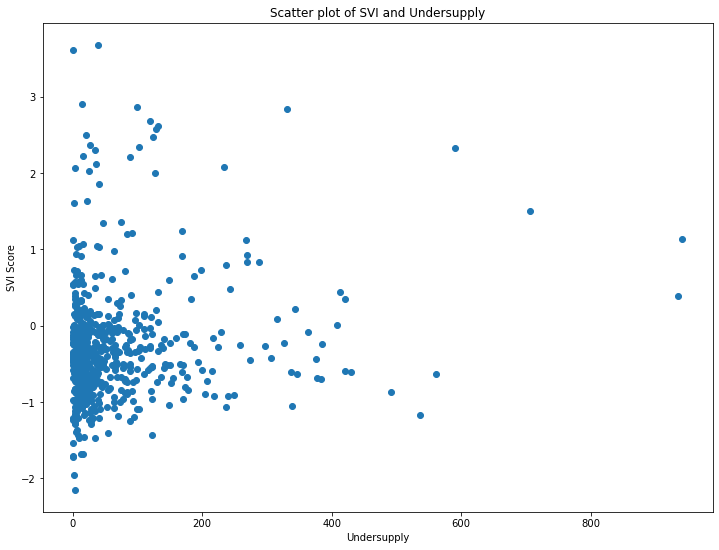

In [7]:
svi_unassigned = penn_lp[2].join(svi_zips.set_index(['ZIP']), on='RATES ZIP', how='left')

plt.figure(figsize=(12,9))
plt.scatter(svi_unassigned['picked'], svi_unassigned['RPL_THEMES'])
plt.xlabel('Undersupply')
plt.ylabel('SVI Score')
plt.title('Scatter plot of SVI and Undersupply')
plt.show()

It seems there is not much correlation between the two. When we look at those with SVI score of over than 2 we see that there are two zip codes that have especially high SVI score and a high number of people that are unassigned. The two outliers are the zip codes 19104 and 19140. Zip code 19104 is located in Philidelphia and has an SVI of 2.33 and an undersupply of 590. Zip code 19140 is also located in Philidelphia with an SVI of 2.83 and an undersupply of 331. These are good candidates for a new OTP provider as they have high numbers of undersupply but are also located in more vulnerable areas.

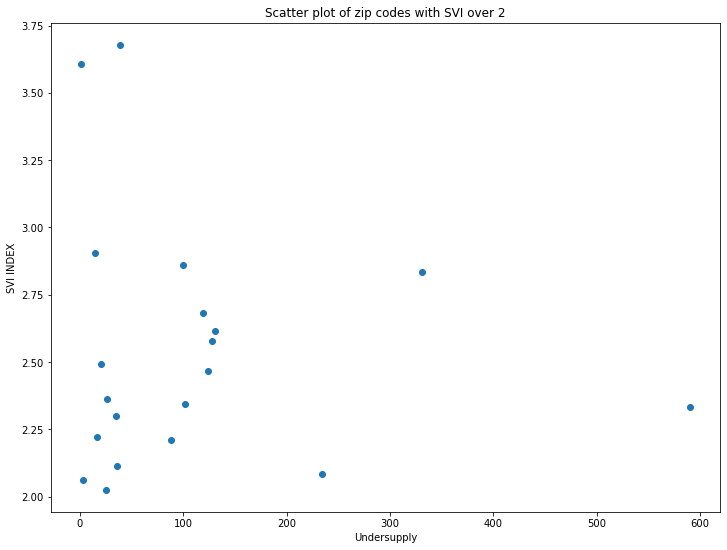

In [8]:
over_2 = svi_zips[svi_zips['RPL_THEMES'] >= 2]

over_2_unassigned = penn_lp[2].join(over_2.set_index(['ZIP']), on='RATES ZIP', how='right')

plt.figure(figsize=(12,9))
plt.scatter(over_2_unassigned['picked'], over_2_unassigned['RPL_THEMES'])
plt.xlabel('Undersupply')
plt.ylabel('SVI INDEX')
plt.title('Scatter plot of zip codes with SVI over 2')

plt.show()